# Project term

Camilo ROMERO <br>
@Eurecom <br>
Data Science - *Fall 2019*

# Title: *Gaussian processes for design of experiments*

## Introduction
Gaussian Processes (GPs) has been shown as an effective alternative approach to regression problems where the uncertainty has to be taken into consideration. In this notebook we are going to address the issue of design of experiments for metamodels that needs to be accurate in some regions of specific functions.

The notebook replicates the adpative strategy for designs of experiments by *Picheny et al* in the paper ***Adaptive Designs of Experiments for Accurate Approximation of a Target Region***. The problem could be seen as constrained optimization where the function is very expensive to evaluate and there is not enought resources to evaluate in multiple points.

A common problem in optimization is when the number of function evaluations is limited by time or cost. One way to address this challenge is to fit response surfaces to data collected by evaluating the objective and constraint functions at a few points. Another way is to try to apporoximate the surface giving a surrogate model. 

## Motivation

A common problem in engineering is when a the outcome of an experiment or the variable of interest is simply not possible to measure or very difficult to get. For instace in order to find an optimal design of aircraft wing or maybe an optimal location of diferent parts of a F1 car, an engineer simulates different scenarios and run multiple simulations to find the best solution. Normally, these simulations take even days to run and they are very expensive. Sometimes is better to approximate them with a subrrogate model.

A surrogate model is an approximation of a real situation and it is used in many engineering problems where the cost to evaluate a problem is very expensive. Thus, a gaussian processes regression is a very useful tool to estimate and evaluate an underlying function which tries to represent the real world with uncertainty. 

In this work we are interested to approximate the function in some region specified for a user under some pre-defined functions.

Before to proceed with all computation, we start to import all the needed libraries.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import solve_triangular
from scipy.stats import norm
from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D

plt.style.use(['seaborn-white'])

### Case 1 Function 2D
The first "costly function" for evaluation is defined below. It's a 2D in a domain of (0,1) and for simplicity terms we generates only 30 points which will be distributed in a grid for later use.

In [3]:
# Number of samples.
n_samples = 30

# Meshgrid with sample data.
nx1 = nx2 = np.linspace(0, 1, n_samples).reshape(-1,1)
X1, X2 = np.meshgrid(nx1, nx2)

# Blackbox function for Case 1.
def func_eval(x1, x2, theta=np.pi/6):

    # Case 1 - 2 dimension data.
    xr_0 = np.cos(theta)*x1 + np.sin(theta)*x2
    xr_1 = -np.sin(theta)*x1 + np.cos(theta)*x2
    
    return np.log(np.sin(2.5*np.pi*xr_0) + 1.5*x1 + 2*xr_1**2 + 1)

The following is a contour plot of the function defined above. To be comprehensible, we remak the target 0 which is the initial region of interest. A user might modify the region later to get an approximation of the function.

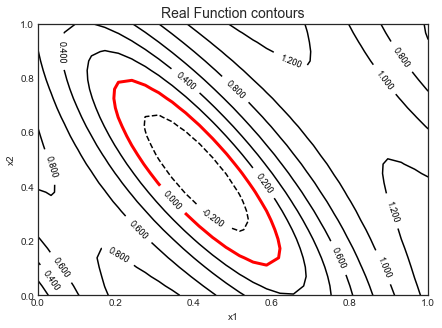

In [4]:
def plot_contour(x1, x2, f, hgt=True, contLins=10, sz=[7,5]):

    fig = plt.figure(figsize=(sz[0], sz[1]))
    cs = plt.contour(x1, x2, f, contLins, colors='k')

    # find index where level has target value.
    if hgt:
        idx = np.where(cs.levels == 0)
        cs.collections[idx[0][0]].set_linewidth(3)
        cs.collections[idx[0][0]].set_color('r')
    plt.clabel(cs, fontsize=9, inline=1)
    return fig 

# Function evaluation for case 1.
f = func_eval(X1, X2)

# plot original function.
plot_contour(X1, X2, f)
plt.title('Real Function contours', fontsize=14)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## How a Gaussian Process help?
In general, a simple approach to find the min/max of a function is to run an optimization algorithm. Normally most of them rely on an iterative process. The problem is the function we are trying to optimize is very expensive and we do not have all resources to run it. In contrast, a response surface could be used to fit the underlying function (which is less costly) and one could try to find the min/max of the surface.

For example imagine you have a real function which is represented in a solid line in the figure below. You start with only few points from the real functions because is really difficult to get them (points are showed as dots). Insted of optimized the function, you opted to approximate it with a subrrogate model such as gaussian process and the result is obtained with the dash line indicated below.

<img width=300px src='img/func.png'>

You see in the region between 4 and 12 of the independed variable the uncertainty associated with a gaussian process is very high because there are many possible functions which could pass over this area. A clever method will be to sample points in this area and evaluate if one of those is the minimun. The iterative process is repeatly many times and could be called experiments. 

<img width=334px src='img/func2.png'>
*source: Jones et al, Efficient Global Optimization of Expensive Black-Box Function*

Now image the process presented in this notebook is very similar to the indicated above but the points will be sample in some area surrounded by a specified target. 

## Guassian process
A gasusian process is not more a distribution over functions which is represented with a gaussian distribution with a mean and the variance. The variance is know as the kernel. There are different types of kernels but the gaussian kernel is one the most used one. Its characteristics of normal transformations add some flexibilities to a respective problem. One of the requirement to apply a guassian kernel is that data have to be smooth. This criteria match almost perfectly with the synthetic data generated before. 

In [5]:
# Guassian Kernel
def gaussian_kernel(x,                # x values (N,1)
                    y,                # y values (N,1)
                    lscl=None,        # l param. for RBF.
                    var=None):        # var param. for RBF.
    
    # Distance between all points.
    dist = distance.cdist(x, y, 'euclidean')
    
    # RBF w/o constrains (length NxN (#pts,#pts))
    return np.exp(- lscl**-2 * dist**2) * var

## Training data
It is normal to have few points at the begining of the experiments because they are really difficult to get. Thus, we considerer the following initial training points and the objective will be the append more points which belongs to some target specified by the user. 

In [6]:
#  training pts.
obs_X_c1 = np.array([[0.98529786, 0.55933787],
                     [0.47589864, 0.37738477],
                     [0.02279748, 0.03577601],
                     [0.77232670, 0.96603697],
                     [0.24643272, 0.78927301]])

print ('Training observed values {}\n'.format(obs_X_c1.shape))
obs_X_c1

Training observed values (5, 2)



array([[0.98529786, 0.55933787],
       [0.47589864, 0.37738477],
       [0.02279748, 0.03577601],
       [0.7723267 , 0.96603697],
       [0.24643272, 0.78927301]])

The functions values associated to each training points are describe below. One thing to remark is to indicate that the functions are very expensive to compute them. They may take hours, day and more. For instance an example is a very deep neural network (DNN). A DNN requieres sometimes too much time and many iterations to aproximate a specific target such as images and so on.

In [7]:
# target value for training data.
obs_F_c1 = func_eval(obs_X_c1[:,0], obs_X_c1[:,1]).reshape(-1,1)

print ('Target observed values {}\n'.format(obs_F_c1.shape))
obs_F_c1

Target observed values (5, 1)



array([[ 1.09212698e+00],
       [-3.15166949e-01],
       [ 2.82343279e-01],
       [ 1.07614532e+00],
       [-4.47456350e-04]])

A contour is plotted to have a general idea where the training points are located in the domain of the function.

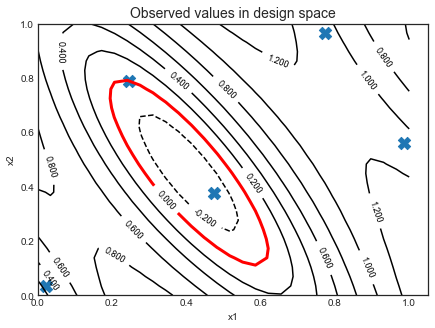

In [8]:
# plot original function.
plot_contour(X1, X2, f)
plt.scatter(obs_X_c1[:,0], obs_X_c1[:,1], marker='X', s=150)
plt.title('Observed values in design space', fontsize=14)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

The following calculation is just make sure that the kernel is calculated correctlly. In this case we assumed a lengthscale equal to 1.

In [9]:
# Test gaussian kernel.
K = gaussian_kernel(obs_X_c1, obs_X_c1, 1, 1)

print ('Kernel (training pts) shape {}\n'.format(K.shape))
print(K)

Kernel (training pts) shape (5, 5)

[[1.         0.74632472 0.30103643 0.80996773 0.54947508]
 [0.74632472 1.         0.72470022 0.64766544 0.8006699 ]
 [0.30103643 0.72470022 1.         0.23998484 0.53914515]
 [0.80996773 0.64766544 0.23998484 1.         0.73505498]
 [0.54947508 0.8006699  0.53914515 0.73505498 1.        ]]


## Hyperparameters search

A gaussian process, like many other statistical model, is subjected to a variarity of hyperparameters that the model depends. If the kernel chosen is the gaussian one, the hyperparameters to be optimized are the lengtscale, the variance proper of the kernal and the noise by minimising the negative log-likelihood of the model using the following formula.

\begin{equation*}
\log p(y|X) := -\frac{1}{2}y^T \alpha - \sum_{i} \log L_i - \frac{n}{2} \log 2\pi
\end{equation*}

In the following piece of code an optimizer is used to determine the best value of the Loss function. A multiple random starts is implemented to avoid local minima.

In [10]:
def hyperParamSearch(x,                         # observed x data.
                     f,                         # observed y data.
                     n_parms=3,                 # No. parameters to be optimized.
                     bnds=(.1, 0.5),            # Bounds where parameters can oscilate.
                     veb=False):                # print best final result.
    
    # The following functions defines the
    # GP's marginal likehood that It's used
    # to determine the bebst hyperparameters
    # for the covariance function. In this case
    # lenghtscale, variance and noise due to 
    # gaussian kernel.
    #
    # arguments:
    # parms => array (1, N) where N is the number
    #          of all hyperparameters.
    #
    # gp_loss needs to maximinize it.
    
    def gp_loss(parms):      

        # compute kernel.
        K = gaussian_kernel(x, x, parms[0], parms[1])

        # Cholesky decomposition of kernel with observations.
        L = np.linalg.cholesky(K + parms[2] * np.eye(len(K)))

        # alpha.
        alpha = solve_triangular(L.T, solve_triangular(L, f, lower=True))

        # Loss fuction.
        L = -0.5*f.T.dot(alpha) - np.sum(np.log(np.trace(L))) - 0.5*len(L)*np.log(2*np.pi)

        return -L
    
    # Initializing arrays to hold best gp loss
    # value and the set of hyperparameters.
    bst_loss = float('inf')
    bst_parms = np.empty((1, n_parms))
    
    # Function to be called by the optimizer
    # to maximize the function.
    def max_loss(x):
        return gp_loss(x)
    
    # Trunked search space for Hyperparms 
    # go from -> ((.000000001, maxFloat))
    bnds = [bnds] * n_parms
    
    # Initialization of random x0 values to avoid local
    # minima. For each x0 value the best minimun is taken.
    bnds = ((0.1,0.5), (0.5,2), (1e-8,0.01))
    print ('Kernel hyperparameter search (wait..)')
    for x0 in np.random.uniform(1e-5, 1e1, size=(n_parms*20, n_parms)):

        res = minimize(max_loss, 
                       x0=x0, 
                       bounds=bnds,
                       method='L-BFGS-B')
        
        if res.fun < bst_loss:
            bst_loss = res.fun
            bst_parms = res.x  
    
    # Print best values.
    print ('...done!')
    if veb:
        print ('\nBest values')
        print ('-----------')
        print ('Loss: {}'.format(-bst_loss))
        print ('Params: {}\n'.format(bst_parms))
        
    return bst_parms

In [11]:
# Determine best hyperparameters values of
# conditional GP with training or observed values.
best_params = hyperParamSearch(obs_X_c1, 
                               obs_F_c1, 
                               veb=True)

Kernel hyperparameter search (wait..)
...done!

Best values
-----------
Loss: [[-7.0839923]]
Params: [4.56391470e-01 2.00000000e+00 2.48147754e-04]



## GP Inference

In addition we define a GP function to make inference. Normally a GP inference has as an outcomes the unbias function value $f(x)$ or mean and the variance of uncertainty associated for each particular point because of the approach developed in this notebook requieres to process some data to get only the variance which does not depend of observed $f(x)$ or $y$ and the mean which does, we split the function in two parts beign more flexible for later usage.

In [12]:
'''
user have to specify which qunatity want to return (mean or variance) 
in the function. In case of no specification, both quantities are returned. 
'''

def gp_inference(x,            # observed x data (x1, x2, .. , xn) -> (n x k).
                 f,            # observed f data (y -> (n x 1)).
                 xpred,        # x data for predictions.
                 params,       # covariance hyperparameters.
                 op='both'):   # GP will compute 'both' => mean, variance 
                               #                 'mean' => mean
                               #                 'var'  => variance
    
    
    # The following variables are essencial
    # by either the mean or variance
    
    # Similarity between train points or observations.
    K = gaussian_kernel(x, x, params[0], params[1])

    # Cholesky decomposition of kernel with observations.
    L = np.linalg.cholesky(K + params[2]*np.eye(len(K)))
    
    # Similarity between prediction and training data.
    K_pred_train = gaussian_kernel(x, xpred, params[0], params[1])
    
    def mean_gp():

        # The following functions computes
        # only the mean predictions using GP.
        # 
        # {The mean depends of the obsberved
        # y values}.

        # alpha.
        alpha = solve_triangular(L.T, solve_triangular(L, f, lower=True))
        
        # mean values.
        mean = np.matmul(K_pred_train.T, alpha).flatten()

        return mean
    
    def var_gp():
            
        # The following functions only
        # computes the variances.
        #
        # {The variance does not depend 
        # of the obsberved y values}.

        # variance values.
        K_pred = gaussian_kernel(xpred, xpred, params[0], params[1])
        v = solve_triangular(L, K_pred_train, lower=True)
        var = K_pred - np.dot(v.T, v)

        return var
    
    if op=='mean':
        return mean_gp()
        
    if op =='var':
        return var_gp()
        
    if op=='both':
        return mean_gp(), var_gp()

GP inference requires as an input a set of independend values of $x$ where you want to get the function values. In this case the predicted values are the grid points defined at the beginning of the notebook. 

In [13]:
# Create test points.
Xpred = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
print('Test point shape: {}'.format(Xpred.shape))

Test point shape: (900, 2)


Run and test the GP inference with 900 predicted values.

In [14]:
# Tet Infer (Posterior) with Gaussian Processes.
mu, var = gp_inference(obs_X_c1, 
                       obs_F_c1, 
                       Xpred, 
                       best_params)

Here again the uncertainty is plotted after performed the inference. For those points which are known, the uncertainty is practically zero and in the regions where we do not have points the uncertainty is different from zero.

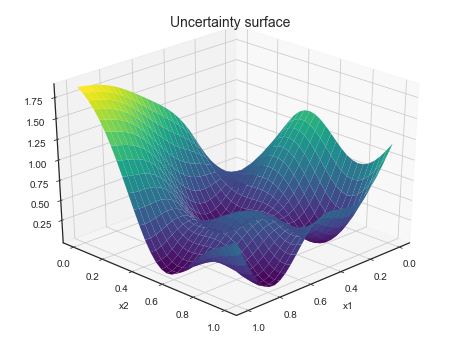

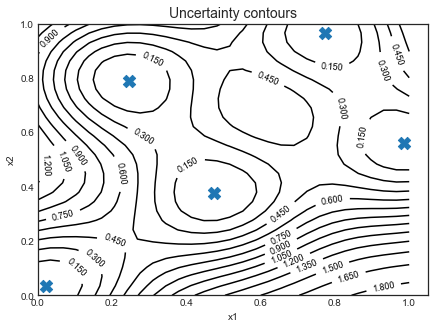

In [15]:
def plot_variance(x, y, f):
    
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, f, cmap='viridis')
    ax.view_init(30,45)
    return fig

# Plot the variance surface
plot_variance(X1, X2, np.diag(var).reshape(X1.shape))
plt.title('Uncertainty surface', fontsize=14)
plt.xlabel('x1')
plt.ylabel('x2')

# Plot the variance contour
plot_contour(X1, X2, np.diag(var).reshape(X1.shape), hgt=False, contLins = 12)
plt.scatter(obs_X_c1[:,0], obs_X_c1[:,1], marker='X', s=150)
plt.title('Uncertainty contours', fontsize=14)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Adaptive approach

One of the key concept in this novel approach to approximate the function in a specified area, target or boundary is the calculation of the following value. So far we have not discussed about the employed methodology. In some scenarios a waste of time and resources can be incurred when you approximate the entire domain of a specific function. Sometimes It is better to have only part of it. 

Imagine you have a 1D function as indicating below. Your goal right now is to get different numbers or experimental independents points only when the target is equal to $T=1$ in this case.

<img width=350px src='img/func1.png'>

The function $y(x)$ can represent everything. For example a spatial surface where your effort is to find crude oil only in some desirable regions or an error level in a neural network, etc. The interest is to get only those points which are located in the area between $[T-\epsilon, T+\epsilon]$. An adaptive and efficient method has been applied to perform that goal because it would be undesire to search the whole space of the function only when we are interested in some target value.

To achieve that goal in particular we need an array $W(x)$ which is a weight representation to encapsulate and ponderate the desire $xnew$ or experimental points. 

\begin{equation*}
W(x_{new}) = \phi \Big(\frac{T + \epsilon - m_k(x)}{s_k(x)} \Big) - \phi \Big(\frac{T - \epsilon - m_k(x)}{s_k(x)} \Big)
\end{equation*}

Where: <br>
$\phi$: is the CDF of standard normal distribution <br>
$x_{new}$: is a weighted value <br>
$T$: is the target <br>
$\epsilon$: is a interval <br>
$m_k(x)$: the mean GP prediction <br>
$s_k(x)$: the variance or uncertainty <br>

If you look very closely the $W(x)$ formula. Those values which belongs to the region of interest will be more ponderated or the value returned is higher.

Finally an optimzer will have to compute the new experimental point which minimize the mean value with the uncertainty associated $s_k(x)$ with the value $x$ on search and the $W(x_{new})$ array as following. 

\begin{equation*}
IMSE_T = \int S_k^2(x) W(x) \, dx
\end{equation*}

In [16]:
# Function to compute prob. vector
# using only observed values over
# all possible prediction location
# in design space.
#
# W(x) is simply the probability that
# the response is inside in the
# interval [T+e,T-2e].
#
# Due to mean value is required and it 
# depends of y obsbervation. The new_x 
# point cannot be included.
    
def weight(xtrain,     # observed x data (x1, x2, .. , xn) -> (M x n).
           ftrain,     # observed f data (y -> (n x 1)).
           xpred,      # x data for predictions.
           parms,      # covariance hyperparameters.
           T=0,        # target of interest.
           ep=0.3):    # range of search (T+e,T-e)

    # Infer W with k observation.
    mu, var = gp_inference(xtrain, 
                           ftrain, 
                           xpred, 
                           parms)
    # Weight.
    W = norm.cdf((T + ep - mu)/np.diag(var)) - norm.cdf((T - ep - mu)/np.diag(var))

    # Weighted vector.
    return W

The following plot is just an indication and to have an idea how the $W_{xnew}$ looks like under certain values of epsilon with the current training set.

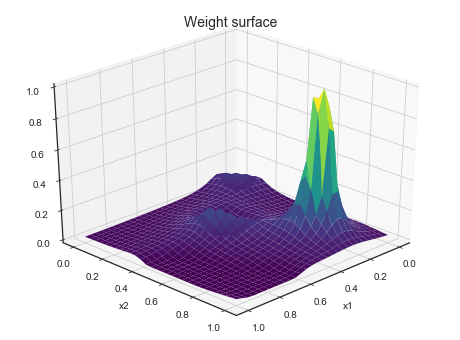

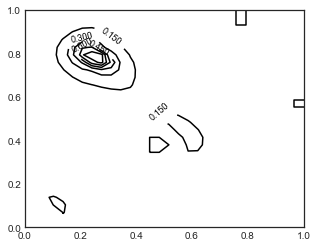

In [17]:
Weight = weight(obs_X_c1, obs_F_c1, Xpred, best_params, ep=0.05)

# Plot the variance surface
plot_variance(X1, X2, Weight.reshape(X1.shape))
plt.title('Weight surface', fontsize=14)
plt.xlabel('x1')
plt.ylabel('x2')

plot_contour(X1, X2, Weight.reshape(X1.shape), hgt=False, contLins=7, sz=[5,4])
# plot_contour(X1, X2, f, contLins=1)
# plt.scatter(obs_X_c1[:,0], obs_X_c1[:,1], marker='X', s=150)
# plt.title('Uncertainty weight contours', fontsize=14)
# plt.xlabel('x1')
# plt.ylabel('x2')
plt.show()

## Design of experiments process

A design of experiments is an interatively process where in conjunction with gaussian processes a new independent $x_{new}$ point will be proposed. The following code was developed as a function able to propose an intelligent next point which belongs to the region of interest. To achieve this, an optimzer with multiple random starts is used to minimize the integral $IMSE_T$ using a monte carlo expectation technique.

The iterative process is as follows:

    1. Get the hyperparameters for the training points.
    2. Compute W(x).
    3. Get the best x point that minimize the integral.
    4. Given x compute the new value of f(x)
    5. Append the new training points to original sets.
    6. Repeat.

In [18]:
def propose_next_point(xtrain,         # observed x values (train data)
                       ftrain,         # obsberved y values (train data)
                       xpred,          # grid (x1,x2) used for predictions
                       w,              # weight vector.
                       params,         # kernel hyperparameters.
                       bnds=(-1,1),    # bounds for inner seach optimization.
                       rt=30):         # restars values to avoid local min.
    
    # data dimension.
    dim = xtrain.shape[1]
    
    def imse_integral(x):
        
        # Get the variance augmenting the
        # training point (xnew). The variance  
        # does not depend of fvalue observations.
        #
        # x = xnew (value to be optimized with
        #           inner optimizer)
        
        xtrain_xnew = np.vstack((xtrain, x))
        var_sk = gp_inference(xtrain_xnew,   # xtrain value augmented xnew
                              None,          # ytrain does not need it
                              xpred,         # pred. set
                              params,
                              op='var')
        
        # approx. integral
        return np.mean(np.diag(var_sk) * w)
        
    # Function to compute the next observed
    # point which minimize the imset integral
    bst_wimse = float('inf')
    bst_pt = np.empty((1, dim))

    def min_obj(x):
        return imse_integral(x)
    
    # Find the best optimum with multiple re-starts.
    # 0 < x1 < 1 ; 0 < x2 < 1
    for x0 in np.random.uniform(bnds[0], bnds[-1], size=(rt, dim)):

        res = minimize(min_obj, 
                       x0=x0, 
                       bounds=[bnds]*dim, 
                       method='L-BFGS-B')
        
        if res.fun < bst_wimse:
            bst_wimse = res.fun
            bst_pt = res.x    
            
    return bst_pt, bst_wimse

The user can specify different types of values for the following parameters of the model such as the target of interest, the numbers of experiments or iterations to execute the code and so on.

In [19]:
# Initial conditions.
'''
iter      => DoE no. iteration.
target:   => Target value of interest.
epsilon:  => epsilon.
restart:  => random restart pts in search fn.
'''

DOEparam = {                           
        'iter'  :25,      # Nmbs of iterations in DOE (Limited by computational costs).                             
        'Tval'  :0,       # Target value of interest.                            
        'ep'    :.001,    # eplison.
        'rest'  :30,      # Nmbs of restarts for inner optimization to avoid local min.
        'bounds':(0,1),   # Design limit space to seach points.
           }

Kernel hyperparameter search (wait..)
...done!
==> DOE No:1 - min Weighted Integral 0.000383435                
Point added: [0.6215, 0.2177]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:2 - min Weighted Integral 0.000331111                
Point added: [0.2612, 0.3216]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:3 - min Weighted Integral 0.000766311                
Point added: [0.6175, 0.3973]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:4 - min Weighted Integral 0.00076382                
Point added: [0.278, 0.6138]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:5 - min Weighted Integral 0.000762198                
Point added: [0.3885, 0.7337]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:6 - min Weighted Integral 0.000760426                
Point added: [0.407, 0.5157]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:7 - min Weighted Integral 0.000758138                
Point added: [0.5255, 0.534]

Ker

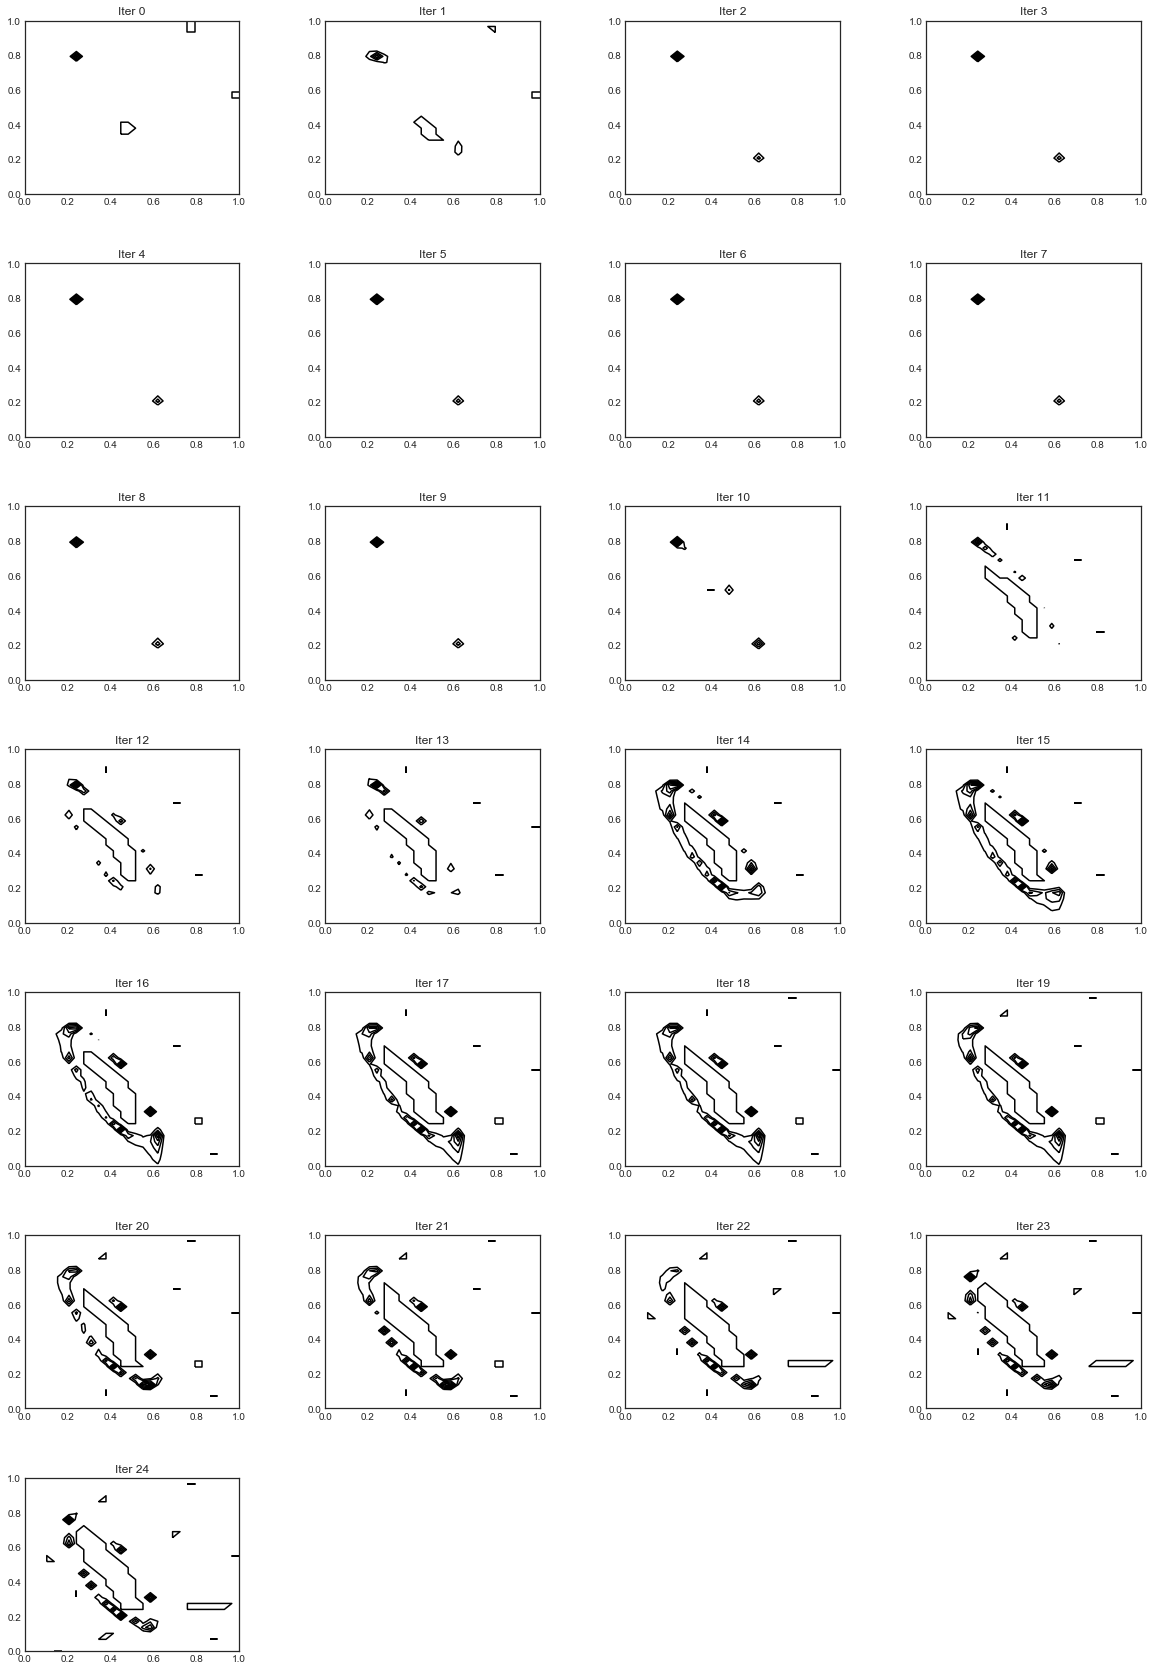

In [20]:
fig = plt.figure(figsize=(20,30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(DOEparam['iter']):

    # Find hyperparameters previous to fit GP.
    bParms = hyperParamSearch(obs_X_c1, 
                              obs_F_c1, 
                              veb=False)
    
    # Weight vector.
    W = weight(obs_X_c1,
               obs_F_c1,
               Xpred,
               bParms,
               T=DOEparam['Tval'],
               ep=DOEparam['ep'],)
    
    # Search for the next smartest point to be SAMPLED.
    x_next_point, wimse = propose_next_point(obs_X_c1, 
                                             obs_F_c1, 
                                             Xpred,
                                             W,
                                             bParms, 
                                             bnds=DOEparam['bounds'],
                                             rt=DOEparam['rest'])
    
    print('==> DOE No:{} - min Weighted Integral {:.6} \
               \nPoint added: [{:.4}, {:.4}]\n'.format(i+1, wimse, 
                                                            x_next_point[0], 
                                                            x_next_point[1]))
    
    # Plot W for each iteration.
#     plot_contour(X1, X2, W.reshape(X1.shape), hgt=False, contLins=6, sz=[4,3])

    # Plot
    ax = fig.add_subplot(math.ceil(DOEparam['iter']/4), 4, i+1)
    ax.contour(X1, X2, W.reshape(X1.shape), 6, colors='k')
    ax.set_title('Iter '+str(i))

    # Eval new searched point in function.
    y_next_point = func_eval(x_next_point[0], x_next_point[1])

    # Add new point to training set.
    obs_X_c1 = np.vstack((obs_X_c1, x_next_point))
    obs_F_c1 = np.vstack((obs_F_c1, y_next_point))

print ('DoE done...')

You see at the begining of the experiment, the points added to the training set are not located in the region of interest because the uncertainty is high in many other regions but after some iterations, the algorithm track down only those near the region specified. As you see, the approximation is not perfect but very accurate. In addition, the $IMSE_T$ is not decreasing all the time, so this approach is not deterministic but tried to be minimized in a general way.

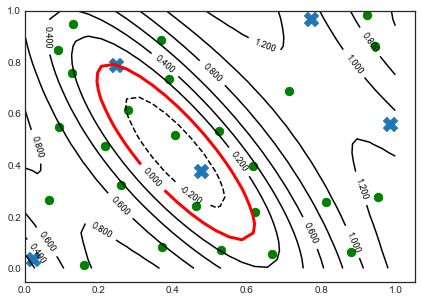

In [21]:
# plot original function.
plot_contour(X1, X2, f)
plt.scatter(obs_X_c1[:5,0], obs_X_c1[:5,1], marker='X', s=200)
plt.scatter(obs_X_c1[5:,0], obs_X_c1[5:,1], marker='o', c='g', s=70)
plt.show()

### Case 2 Function 3D
Now we have a second function which is defined below. Normally adding an extra dimension to a dataset will increase the complexity of the interative process of the design of experiment.

In [22]:
# Number of samples.
n_samples = 10

nx1 = nx2 = nx3 = np.linspace(0, 3, n_samples).reshape(-1,1)
X1, X2, X3 = np.meshgrid(nx1, nx2, nx3)

# real functions.
def func_eval_c2(x):
    '''
    The following function is used to compute
    the function value for training points
    '''
    
    c1, r1 = np.array([[.1],[.3],[.75]]), 0.02
    c2, r2 = np.array([[.15],[.8],[.5]]), 0.06
    c3, r3 = np.array([[.8],[.2],[.2]]),  0.02
    
    d1 = np.sum((x.T - c1)**2, axis=0) - r1
    d2 = np.sum((x.T - c2)**2, axis=0) - r2
    d3 = np.sum((x.T - c3)**2, axis=0) - r3
    
    s1 = np.sin(5*d1)+0.01*d1
    s2 = np.sin(4*d2)+0.01*d2
    s3 = np.sin(3*d3)+0.02*d3
    
    return s1+s2+s3

## Training data

In this second experiment, few points are given and load it to the notebook. They are presented below. 

In [23]:
# Training data (dependent values).
obs_X_c2 = pd.read_csv('~/Downloads/inputsCase2.csv', sep = ',').values
print ('Training observed values {}\n'.format(obs_X_c2.shape))
obs_X_c2[:5]

Training observed values (30, 3)



array([[0.06307849, 0.52767306, 0.23942085],
       [0.80421388, 0.02876601, 0.1697321 ],
       [0.75775574, 0.35830168, 0.09496949],
       [0.90550578, 0.65924051, 0.75630914],
       [0.73147696, 0.37883966, 0.54655965]])

As equal the number of expensive observation of $f(x)$ are presented below.

In [24]:
# Eval function case 1.
obs_F_c2 = func_eval_c2(obs_X_c2).reshape(-1,1)
print ('Target observed values {}\n'.format(obs_F_c2.shape))
obs_F_c2[:5]

Target observed values (30, 1)



array([[ 2.30979765],
       [-1.82120284],
       [-0.36402599],
       [ 1.10577633],
       [ 2.22363853]])

In [25]:
# # Test gaussian kernel.
# K = gaussian_kernel(obs_X_c2, obs_X_c2, 1, 1)

# print ('Kernel (training pts) shape {}\n'.format(K.shape))
# print(pd.DataFrame(K[:7,:7]))

In [26]:
# # Call function to perform hyperparamets search.
# best_params = hyperParamSearch(obs_X_c2, 
#                                obs_F_c2, 
#                                veb=True)

GP inference requires as an input a set of independend values of $x$ where you want to get the function values. Those value are summarized below.

In [27]:
# Test points.
Xpred = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1), X3.reshape(-1,1)))

print('Test point shape: {}'.format(Xpred.shape))

# # Tet Infer (Posterior) with Gaussian Processes.
# mu, var = gp_inference(obs_X_c2, 
#                        obs_F_c2, 
#                        xpred, 
#                        best_params,
#                        op='both')

Test point shape: (1000, 3)


The user also has the oportuninty to modify some parameters of the model to see different behavior. To change the value, just alter the values of the dictionary.

In [28]:
# Initial conditions.
'''
iter      => DoE no. iteration.
target:   => Target value of interest.
epsilon:  => epsilon.
restart:  => random restart pts in search fn.
'''

doeParms = {                           
        'iter'  :15,       # Nmbs of iterations in DOE (Limited by computational costs).                             
        'Tval'  :2,       # Target value of interest.                            
        'ep'    :.05,      # eplison.
        'rest'  :20,      # Nmbs of restarts for inner optimization to avoid local min.
        'bounds':(0,3),   # Design limit space to seach points.
           }

In [29]:
for i in range(doeParms['iter']):

    # Find hyperparameters.
    bParam = hyperParamSearch(obs_X_c2, 
                              obs_F_c2, 
                              veb=False)
    
    # Weight vector.
    W = weight(obs_X_c2,
               obs_F_c2,
               Xpred,
               bParms,
               T=DOEparam['Tval'],
               ep=DOEparam['ep'],)
    
    
    # Search for the next smartest point to be SAMPLED.
    x_next_point, wimse = propose_next_point(obs_X_c2, 
                                             obs_F_c2, 
                                             Xpred,
                                             W,
                                             bParms, 
                                             bnds=DOEparam['bounds'],
                                             rt=DOEparam['rest'])
    
    print('==> DOE No:{} - min Weighted Integral {:.6} \
               \nPoint added: [{:.4}, {:.4}, {:.4}]\n'.format(i+1, wimse, 
                                                          x_next_point[0],
                                                          x_next_point[1],
                                                          x_next_point[2]))

    # Eval new searched point in function.
    y_next_point = func_eval_c2(np.expand_dims(x_next_point, axis=0))

    # Add new point to training set.
    obs_X_c2 = np.vstack((obs_X_c2, x_next_point))
    obs_F_c2 = np.vstack((obs_F_c2, y_next_point))

print ('DoE done...')

Kernel hyperparameter search (wait..)
...done!
==> DOE No:1 - min Weighted Integral 0.000781333                
Point added: [0.7408, 0.004696, 0.08644]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:2 - min Weighted Integral 0.000780579                
Point added: [0.6688, 0.9956, 0.9005]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:3 - min Weighted Integral 0.00078053                
Point added: [0.1932, 0.02517, 0.9662]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:4 - min Weighted Integral 0.000780152                
Point added: [0.9246, 0.2839, 0.02802]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:5 - min Weighted Integral 0.000779346                
Point added: [0.08521, 0.9911, 0.9304]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:6 - min Weighted Integral 0.000779161                
Point added: [0.004151, 0.9741, 0.6311]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:7 - min Weighted Integral 0.0

Unfortunately because of adding an extra dimension in the data, we are not able to plot to see whether the function match with the desirable target but analyzing the points which have been added many of them are very close together. 

## Conclusion

The design of experiments is a very broad methodology and used in different aspects of engineering. In many processes it is required to simulate different scenarios in order to determine an optimal output. Many of the experiments require simulations that involve a lot of calculation time and it is not possible, in certain cases, to have an adequate response.

In the present book a methodology was studied to approximate functions in certain regions of interest. This method is very useful, since it can accelerate optimization calculations directed to certain areas of the function. As it was observed, two functions were used to determine the performance of the something.

At the beginning the points added to the training set are far from the area of interest and it is for obvious reasons. The uncertainty in the areas where certain points are known is low and therefore the integral will be low equal, but after some iterations, it is clearly observed that the algorithm begins to converge in the area of interest. The interesting thing here is that the IMSE does not decrease in each iteration, which indicates that the search process is not deterministic, but stochastic, but after some experiments, its value decreases.

It is important to indicate that the approach level of the region will depend on the chosen value of epsilon, which acts as an interval for the search. A very small value, will concentrate more values in the region, while a higher value, will alleviate the search for the optimizer.

This methodology can be used in many applications in which obtaining training data is almost impossible or very expensive and requires an intelligent search in the search domain of interest of the engineer.

## References
- Picheny et al, Adaptive Designs of Experiments for Accurate Approximation of a Target Region.
- Jones et al, Efficient Global Optimization of Expensive Black-Box Functions.
- Rasmussen, C, Gaussian Processes in Machine Learning.
- http://krasserm.github.io/2018/03/21/bayesian-optimization/